In [10]:
import numpy as np
import librosa
from librosa import display
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp
from tqdm import tqdm

In [11]:
classes = ['Distortion', 'Tremolo', 'NoFX']
n_centroids = 173
dict_train_features = {'Distortion': [], 'Tremolo': [], 'NoFX': []}

for c in tqdm(classes):
    train_root = 'inputs/{}/training/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')]
    n_train_samples = len(class_train_files)
    
    train_features = np.zeros((n_train_samples, n_centroids))
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        centroids = librosa.feature.rms(audio, frame_length=1024, hop_length=512)
        train_features[index, :] = centroids
        

    dict_train_features[c] = train_features    

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 133.22it/s]


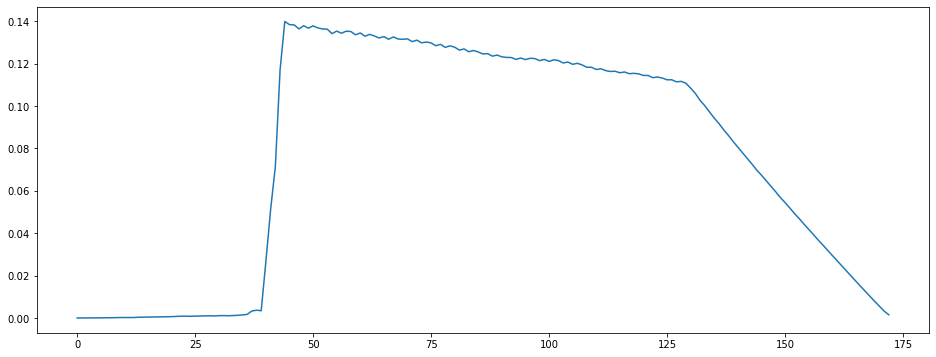

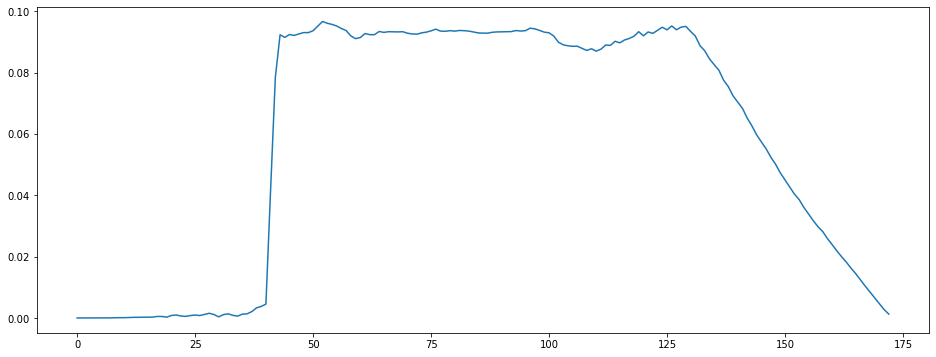

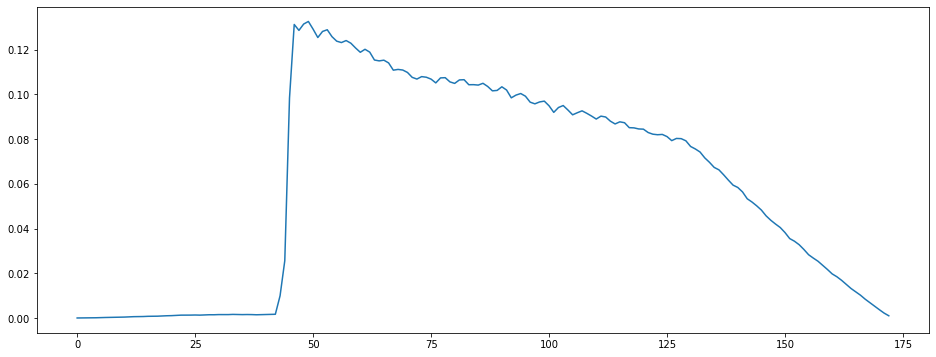

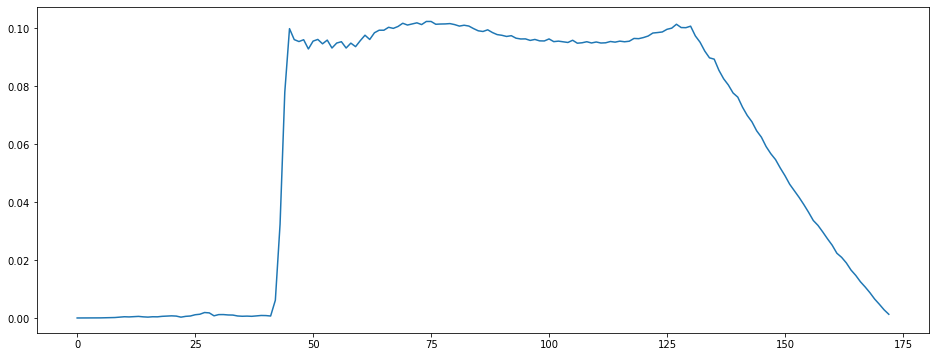

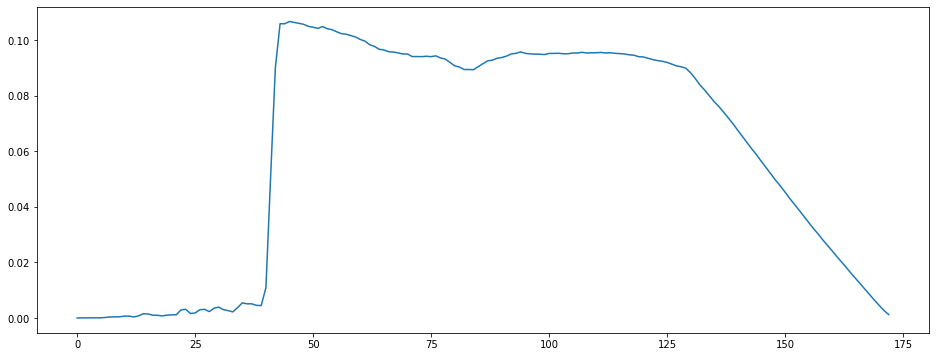

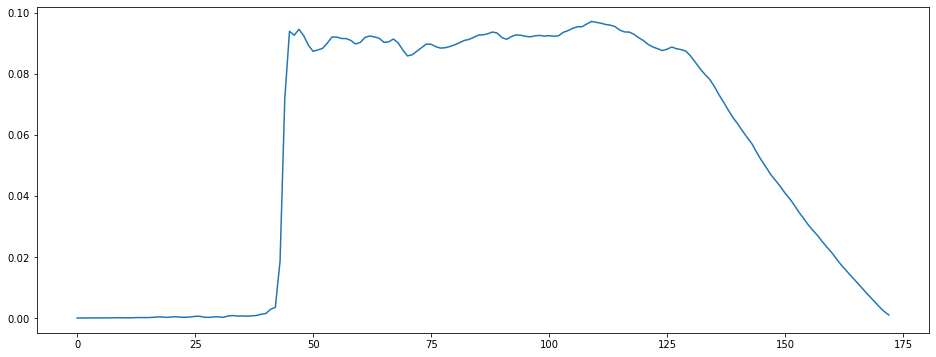

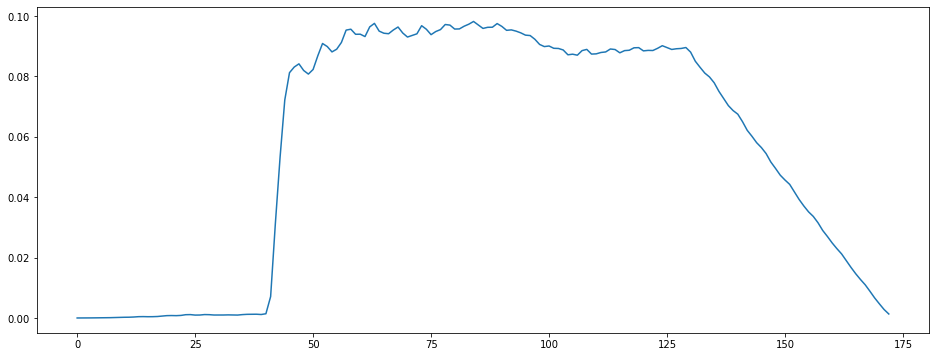

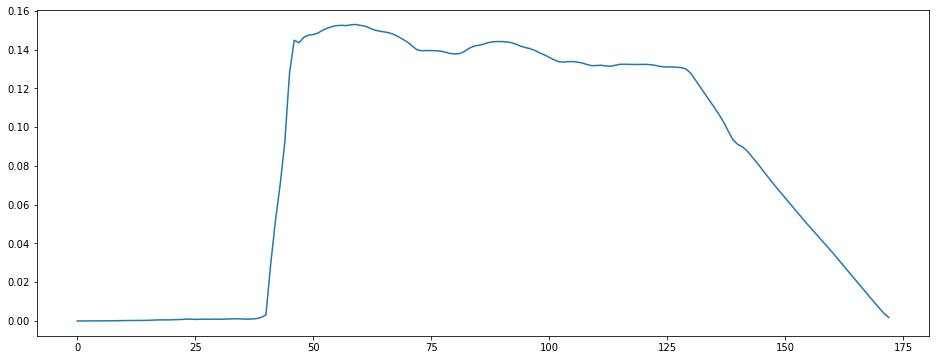

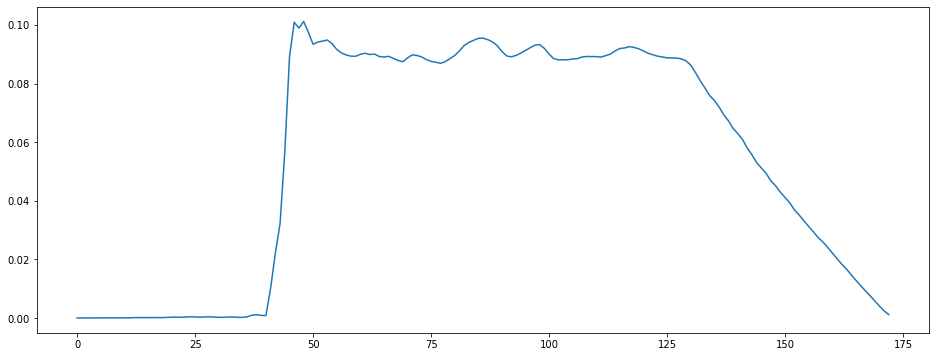

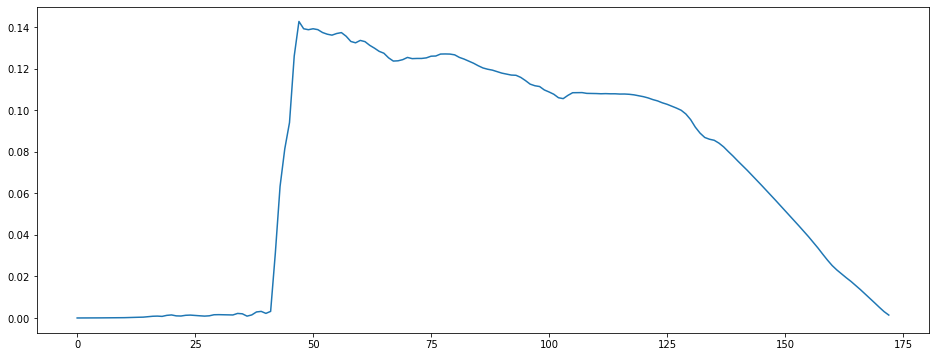

In [12]:
for cents in dict_train_features["Distortion"]:
    fig = plt.figure(figsize=(16, 6))
    plt.plot(np.arange(n_centroids), np.transpose(cents))


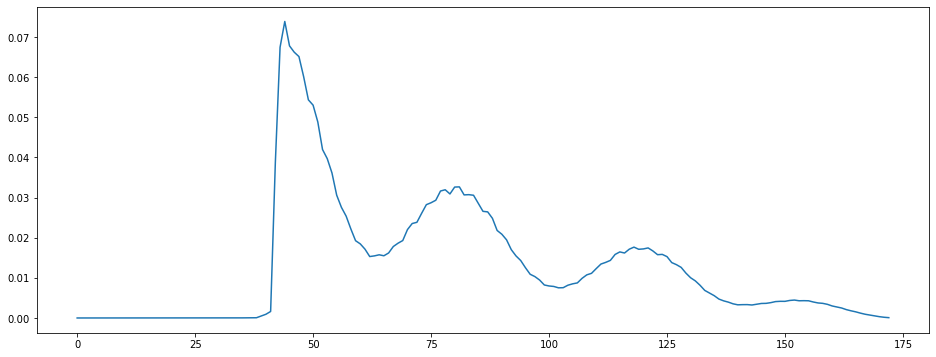

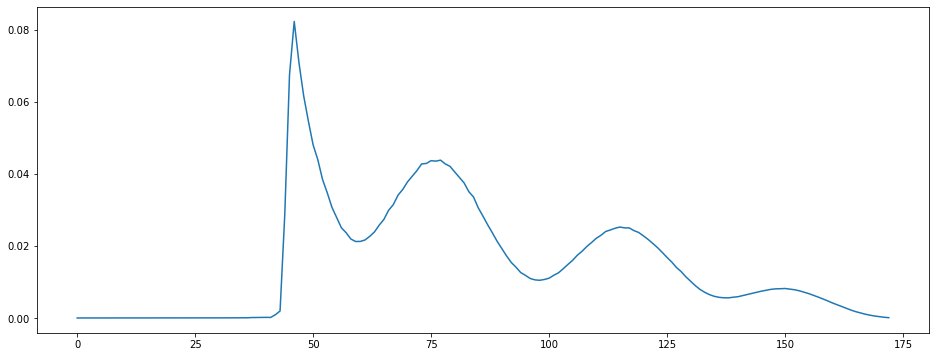

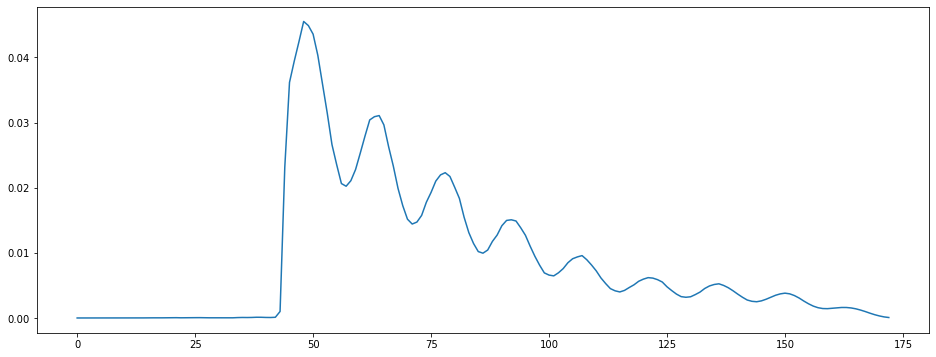

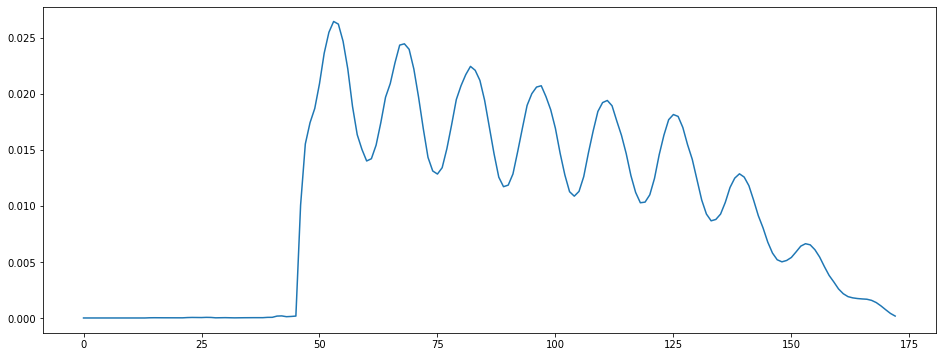

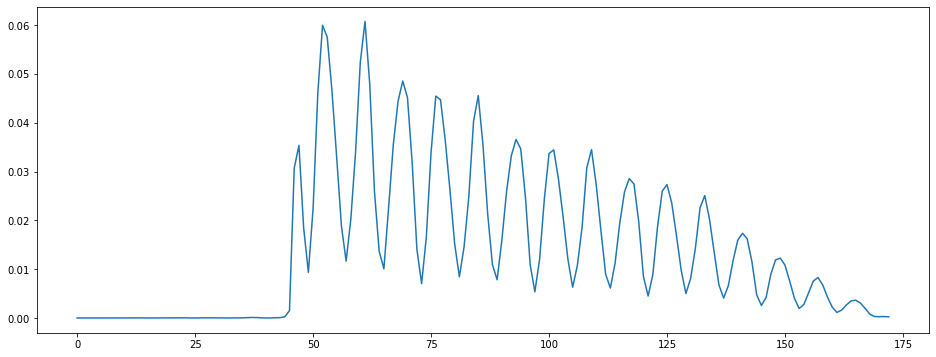

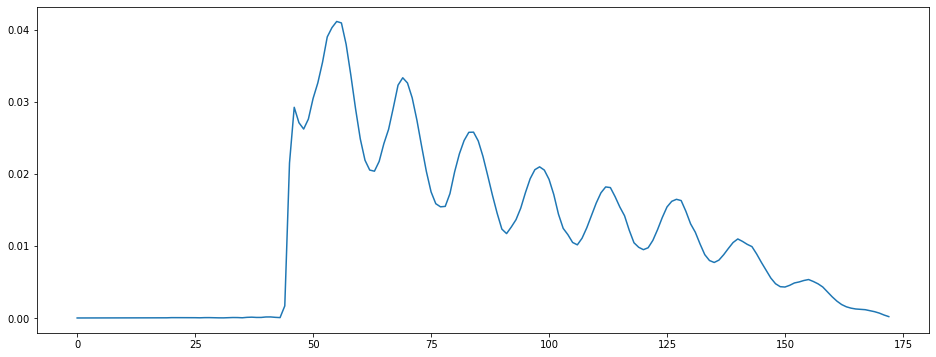

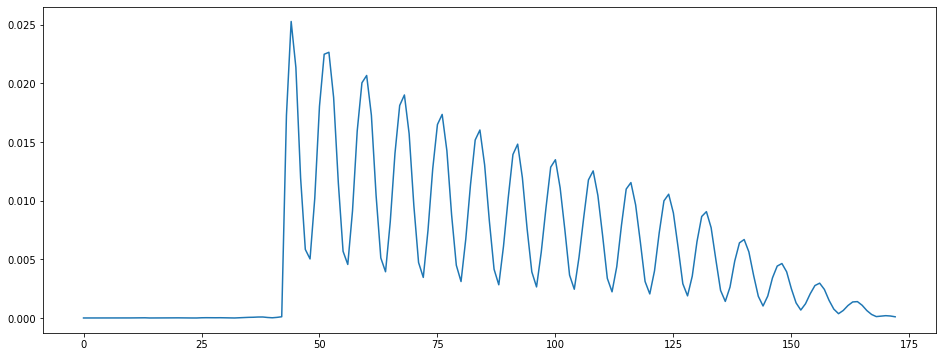

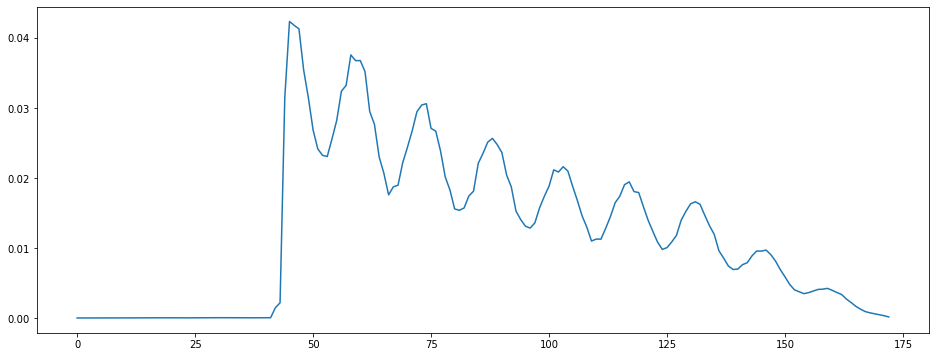

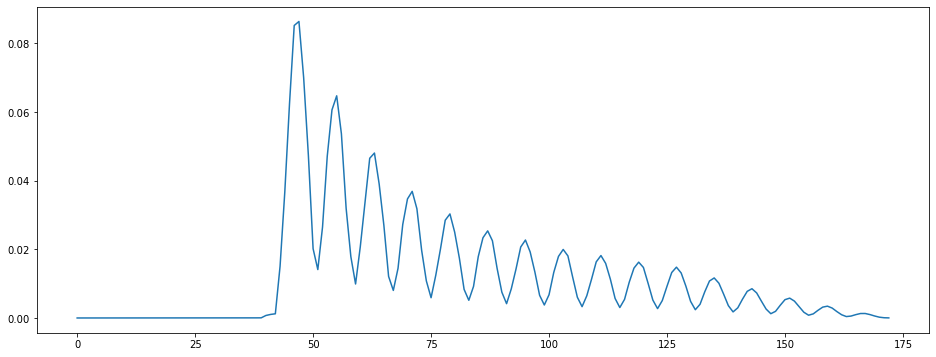

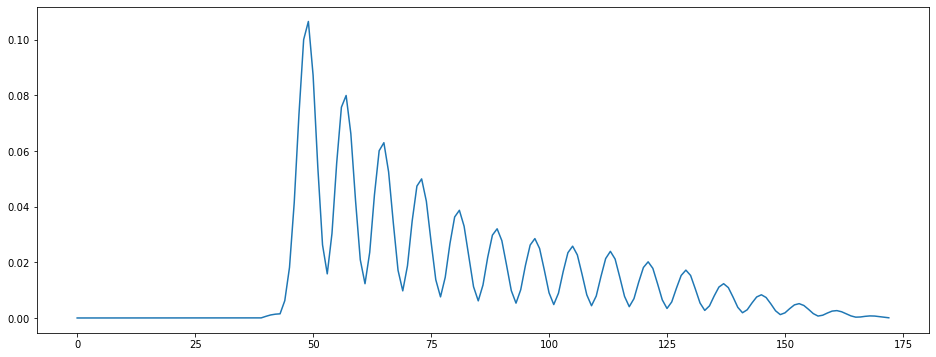

In [13]:
for cents in dict_train_features["Tremolo"]:
    fig = plt.figure(figsize=(16, 6))
    plt.plot(np.arange(n_centroids), np.transpose(cents))

In [14]:
dict_test_features = {'Distortion': [], 'Tremolo': [], 'NoFX': []}

for c in tqdm(classes):
    test_root = 'inputs/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.wav')]
    n_test_samples = len(class_test_files)
    
    test_features = np.zeros((n_test_samples, n_centroids))
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        centroids = librosa.feature.rms(audio, frame_length=1024, hop_length=512)
        test_features[index, :] = centroids
        
    dict_test_features[c] = test_features

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.34it/s]


In [15]:
class_0 = 'Distortion'
class_1 = 'Tremolo'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]

X_train = np.concatenate((X_train_0, X_train_1), axis=0)

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))

y_train = np.concatenate((y_train_0, y_train_1), axis=0)

In [16]:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]

X_test = np.concatenate((X_test_0, X_test_1), axis=0)

y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))

y_test = np.concatenate((y_test_0, y_test_1), axis=0)

In [17]:
feat_max = np.max(X_train, axis=0)
feat_min = np.min(X_train, axis=0)
X_train_normalized = (X_train - feat_min) / (feat_max - feat_min)
X_test_normalized = (X_test - feat_min) / (feat_max - feat_min)

In [18]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf = sklearn.svm.SVC(**SVM_parameters)

In [19]:
clf.fit(X_train_normalized, y_train)

SVC(C=1)

In [20]:
def compute_metrics(gt_labels, predicted_labels):
    TP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 1))
    FP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 0))
    TN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 0))
    FN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 1))
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    print("Results : \n accuracy = {} \n precision = {} \n recall = {} \n F1 score = {}".format(
        accuracy, precision, recall, F1_score))


In [21]:
y_test_predicted = clf.predict(X_test_normalized)

compute_metrics(y_test, y_test_predicted)

Results : 
 accuracy = 1.0 
 precision = 1.0 
 recall = 1.0 
 F1 score = 1.0


In [22]:
class_0 = 'Distortion'
class_1 = 'Tremolo'
class_2 = 'NoFX'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2

#y_train = np.concatenate((y_train_class_0, y_train_class_1, y_train_class_1), axis=0)

In [23]:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]


y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2

y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)

In [24]:
feat_max = np.max(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)
feat_min = np.min(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)

X_train_0_normalized = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (X_train_2 - feat_min) / (feat_max - feat_min)

X_test_0_normalized = (X_test_0 - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (X_test_1 - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (X_test_2 - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized), axis=0)


In [25]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)


In [26]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

SVC(C=1, probability=True)

In [27]:
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)

In [28]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_12), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

In [29]:
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

In [30]:
def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [31]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)

[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  1.  9.]]
